<a href="https://colab.research.google.com/github/fantajeon/DLPytorch1.2/blob/master/Chapter1_MLP_Criteo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Criteo MLP #
Author: fantajeon@gmail.com

Criteo는 Kaggle 사이트통해서 공개한 데이터 셋입니다. 이 데이터의 목적은 사용자의 click을 예측하는 데이터 셋입니다. 라벨과 특징으로 구성되어 있습니다. 이 데이터셋의 특징은 특징에 대한 특별한 설명을 하지 않습니다. 보안때문이라고 이야기 했습니다. 이러한 특징때문에 딥러닝 개발자들이 실험에 즐겨 쓰는 데이터셋입니다. 아무런 도메인 지식없이, 순전히 모델만으로 성능을 내기 때문입니다.
최신 트렌드 [성능 표](https://paperswithcode.com/paper/xdeepfm-combining-explicit-and-implicit#code)를 참조하세요.

본 강좌에서는 필요한 처리들이 많아서, 일부 특징 만 사용할 계획입니다. 

라벨: 
*   1 - 클릭했다.
*   0 - 클릭 안 했다.

특징:
* I1-I13: 연속 특징
* C1-C24: 카테고리 특징

In [2]:
!pip -q install --upgrade torch==1.2.0
!pip -q install torchnet
!pip install --upgrade tqdm==4.28.1

     |████████████████████████████████| 686kB 10.3MB/s 
     |████████████████████████████████| 204kB 52.7MB/s 
Requirement already up-to-date: tqdm==4.28.1 in /usr/local/lib/python3.6/dist-packages (4.28.1)


In [3]:
import torch
from torch import nn
import torch.optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import torch.utils.data as data
from IPython.core.debugger import set_trace   # jupyter notebook에서 breakpoint를 하는 방법
import torchnet.meter as meter
import tqdm
import matplotlib.pyplot as plt

torch.__version__


'1.2.0'

In [0]:
!wget -q https://raw.githubusercontent.com/ycjuan/kaggle-2014-criteo/master/train.tiny.csv -O ./train.csv
!wget -q https://github.com/fantajeon/DLPytorch1.2_Materials/raw/master/test_tiny.csv -O ./test.csv

In [0]:
test_data = pd.read_csv("test.csv", header=None)
train_data = pd.read_csv("train.csv")
train_data = train_data.iloc[:,1:]
print("len(train)", train_data.shape, "len(test)", test_data.shape)
train_data.head(5)


len(train) (1999, 40) len(test) (10000, 40)


,Label,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,1.0,2.0,NaN,2.0,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,NaN,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,1.0,1.0,NaN,4.0,68fd1e64,f0cf0024,6f67f7e5,41274cd7,25c83c98,fe6b92e5,922afcc0,0b153874,a73ee510,2b53e5fb,4f1b46f3,623049e6,d7020589,b28479f6,e6c5b5cd,c92f3b61,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,NaN,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,1.0,3.0,3.0,45.0,287e684f,0a519c5c,02cf9876,c18be181,25c83c98,7e0ccccf,c78204a1,0b153874,a73ee510,3b08e48b,5f5e6091,8fe001f4,aa655a2f,07d13a8f,6dc710ed,36103458,8efede7f,3412118d,NaN,NaN,e587c466,ad3062eb,3a171ecb,3b183c5c,NaN,NaN
3,0,NaN,893,NaN,NaN,4392.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,68fd1e64,2c16a946,a9a87e68,2e17d6f6,25c83c98,fe6b92e5,2e8a689b,0b153874,a73ee510,efea433b,e51ddf94,a30567ca,3516f6e6,07d13a8f,18231224,52b8680f,1e88c74f,74ef3502,NaN,NaN,6b3a5ca6,NaN,3a171ecb,9117a34a,NaN,NaN
4,0,3.0,-1,NaN,0.0,2.0,0.0,3.0,0.0,0.0,1.0,1.0,NaN,0.0,8cf07265,ae46a29d,c81688bb,f922efad,25c83c98,13718bbd,ad9fa255,0b153874,a73ee510,5282c137,e5d8af57,66a76a26,f06c53ac,1adce6ef,8ff4b403,01adbab4,1e88c74f,26b3c7a7,NaN,NaN,21c9516a,NaN,32c7478e,b34f3128,NaN,NaN


In [0]:
test_data.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,1,NaN,0,4.0,1.0,17714.0,66.0,2.0,11.0,62.0,NaN,1.0,NaN,1.0,24eda356,207b2d81,6a061171,ef6ae422,25c83c98,6f6d9be8,b5043bcd,0b153874,a73ee510,b78f3a55,371dae82,2dad7b23,18fc2b1e,07d13a8f,0c67c4ca,722ee340,d4bb7bd8,395856b0,21ddcdc9,b1252a9d,aec73e74,NaN,32c7478e,215dcc2f,001f3601,05051329
1,0,10.0,12,19.0,30.0,4.0,30.0,10.0,30.0,30.0,1.0,1.0,NaN,30.0,05db9164,e5fb1af3,50f62395,e3b436dd,4cf72387,7e0ccccf,095d6b9e,0b153874,a73ee510,94c7e002,8f736c02,b735321f,954f731f,b28479f6,23287566,76a47423,e5ba7672,13145934,0053530c,b1252a9d,d4815352,NaN,bcdee96c,2ef19589,f7839e21,eadff93b
2,1,NaN,6,116.0,10.0,27329.0,NaN,0.0,29.0,1.0,NaN,0.0,NaN,22.0,8cf07265,73a46ff0,dd1e882e,f34203e3,25c83c98,7e0ccccf,3b870555,5b392875,a73ee510,3b08e48b,39ec7a77,0a48382f,66bf004c,b28479f6,4f648a87,4e669708,776ce399,da507f45,21ddcdc9,5840adea,81f8acaf,NaN,be7c41b4,15b4ecfa,ea9a246c,9636866f
3,0,NaN,-1,NaN,NaN,5713.0,NaN,0.0,1.0,14.0,NaN,0.0,NaN,NaN,05db9164,4c2bc594,d032c263,c18be181,25c83c98,fe6b92e5,646b4bca,0b153874,a73ee510,3b08e48b,45ea640a,dfbb09fb,df941d33,8ceecbc8,c7b09696,84898b2a,d4bb7bd8,fe94fad1,NaN,NaN,0014c32a,ad3062eb,3a171ecb,3b183c5c,NaN,NaN
4,0,0.0,1,NaN,10.0,28841.0,NaN,0.0,10.0,5.0,0.0,0.0,NaN,10.0,05db9164,b46aceb6,NaN,NaN,b0530c50,7e0ccccf,b5e1898d,0b153874,a73ee510,3b08e48b,5d1b7285,NaN,cb2e33ed,07d13a8f,217d99f2,NaN,07c540c4,908eaeb8,NaN,NaN,NaN,NaN,be7c41b4,NaN,NaN,NaN


#연속필드만으로 예측#

In [0]:
class MLP(torch.nn.Module):
  def __init__(self, input_dim, hidden_dims, output_dim):
    super(MLP, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    layers = []
    ndims = [self.input_dim] + hidden_dims + [output_dim]
    for i in range(0, len(hidden_dims)+1):
      seq = nn.Sequential( 
          nn.Linear(ndims[i], ndims[i+1]),
          nn.BatchNorm1d(ndims[i+1]),
          nn.ReLU()
      )
      layers.append( seq )
    self.layers = nn.ModuleList( layers )
    self.init_weight()

  def forward(self, x):
    for i, layer in enumerate(self.layers):
      x = layer(x)
    return x

  def init_weight(self):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in')
        nn.init.constant_(m.bias, 0.)
      elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight, 1.)
        nn.init.constant_(m.bias, 0.)

## 데이터 정제 ##

In [0]:
def preprocess(data):
  # NaN은 의미있는 숫자가 아니므로 계산을 할 수 없습니다. 여러 방법이 있지만, 평균값을 채워 넣는다.
  c_label = data.iloc[:,0].values
  c_data = data.iloc[:,1:14].values
  for i in range(c_data.shape[1]):
    invalid_idx = np.isnan(c_data[:,i])
    mean = c_data[~invalid_idx,i].mean()   # NaN아닌 데이터의 평균 계산
    c_data[invalid_idx,i] = mean  # NaN을 평균값으로 대체

  c_data = torch.tensor(c_data, dtype=torch.float32)
  c_label = torch.tensor(c_label, dtype=torch.int64)  
  return c_data, c_label

### Train Data Set 정제 ###

In [0]:
c_train_data, c_train_label = preprocess(train_data)
ds = data.TensorDataset(c_train_data, c_train_label )
train_loader = data.DataLoader(ds, batch_size=128, shuffle=True)

In [0]:
c_train_label.sum()

tensor(418)

### Test Data Set 정제 ###

In [0]:
c_test_data, c_test_label = preprocess(test_data)
ds = data.TensorDataset(c_test_data, c_test_label )
test_loader = data.DataLoader(ds, batch_size=1000, shuffle=True)

In [0]:
c_test_label.sum()

tensor(2608)

## Loss 함수 설계 ##
Negative Cross Entropy Loss 함수 설계
$$Loss(y,\hat{y}) = - \frac{1}{N}\sum_{N}{\sum_{c \in Classes} { y_c * log(\hat{y_c})} }$$

보통 Loss라하면, 작은값이 더 좋은 최적해를 찾도록 설계합니다. 여러가지 해석을 할 수 있지만, 최적화의 관점에서 $y$는 보통 고정시켜 놓습니다. 그리고 $\hat{y}$는 모델로 예측한 확률값입니다. 이것을 target이라고 이야기 합니다. target과 얼마나 비슷하게 예측하는 지를 측정할 수 있습니다. 결과적으로 Cross Entropy는 두 확률분포가 비슷하면 0에 가까워지고, 다를수록 값이 커집니다.

###  Cross entropy를 위해서 출력값 표현 설계 ###

True $y$, target 설계, One-Hot Encoding 기법(하나만 1인 형태)
* label이 1일 경우, y = [0, 1]  
* label이 0일 경우, y = [1, 0]

예측 $\hat{y}$의 설계
* posivie 예측일 경우, $\hat{y}$ = [0.01, 0.99]
* 그렇지 않을 경우, $\hat{y}$ = [0.99, 0.01]

위 공식을 구현하는 게 처음할때는 힘들고, 계산의 안정적인 측면도 고려를 해야 합니다. 이러면 복잡해집니다. 하지만 PyTorch는 이러한 부분도 내장된 함수로 제공합니다. Torch Manual에서 [loss](https://pytorch.org/docs/stable/nn.html#loss-functions) 편을 참조 하시기 바랍니다. 많이 존재합니다. torch.nn.BCEWithLogitsLoss()입니다. 여기서 target은 [0, 1] 또는 [1, 0] 두 2가지 경우밖에 없는 binray 집합입니다.

#### -log(x) ####

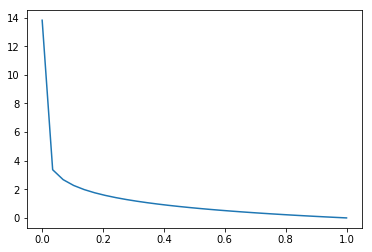

In [0]:
# -log(x)의 그래프
import matplotlib.pyplot as plt
x = np.linspace(1e-6,1,30)
neg_log_y = -np.log(x)

plt.plot(x,neg_log_y)

In [0]:
# Negative Cross Entropy 실험
def negative_cross_entropy(y1, y2):
  return -(y1*torch.log(y2)).mean()

a = torch.tensor([0.1, 0.9], dtype=torch.float32)
b = torch.tensor([0.9, 0.1], dtype=torch.float32)
print(negative_cross_entropy(a,b))

a = torch.tensor([0.9, 0.1], dtype=torch.float32)
b = torch.tensor([0.9, 0.1], dtype=torch.float32)
print(negative_cross_entropy(a,b))

a = torch.tensor([0.5, 0.5], dtype=torch.float32)
b = torch.tensor([1-1e-3, 1e-3], dtype=torch.float32)
print(negative_cross_entropy(a,b))

a = torch.tensor([1.0, 0.0], dtype=torch.float32)
b = torch.tensor([1-1e-6, 1e-6], dtype=torch.float32)
print(negative_cross_entropy(a,b))


tensor(1.0414)
tensor(0.1625)
tensor(1.7272)
tensor(5.0664e-07)


#### One-Hot Encoder, Target Encoding ####
벡터의 원소 중 단 1개만 1로하고 나머지는 0인 형태로 만들어 주는 것

In [0]:
def one_hot_encoder(y, nclass):
  label = torch.zeros(y.size(0), nclass, dtype=torch.float32)
  label.scatter_(1,y.unsqueeze(1),1.0)
  return label

nclass = 2
y = torch.tensor([1,0,1,1,0])
one_hot_encoder(y,2)

tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])

여기서는 BCEWithLogitsLoss()를 사용할 것입니다. CrossEntropy 기법인데, 2개의 클래스를 분류하는 문제에 잘 설계되어있습니다. 또한 조금 더 수치적으로 안정적인 계산 방법입니다. 예를들면 단순히 cross entropy를하면 log(0)은 -inf로 나와서 loss 값이 엉망이 됩니다. 이러면 더 이상 학습이 힘들 수 있습니다.

In [0]:
loss = torch.nn.BCEWithLogitsLoss()

true_y = torch.tensor( [0,1,0] )
pred_y = torch.tensor( [[0.1, 0.9], [0.2, 0.8], [0.9, 0.1]], dtype=torch.float32 )
label_y = one_hot_encoder(true_y, 2)

loss(label_y, pred_y)

tensor(0.7032)

### 정확도 계산 ###


In [0]:
def check_accuracy(model, dataloader, mtr):
  x, true_y = next(dataloader)
  with torch.no_grad():
    logit_y = model(x)
    cls_prob = F.softmax(logit_y,dim=1)
    pred_y = cls_prob.argmax(dim=1)
    acc = (pred_y == true_y).type(dtype=torch.float32).mean()
    mtr.add(cls_prob[:,1], true_y)
  return acc


# 이제 학습을 시작해 보자 #

In [0]:

model = MLP(13,[200,200,200], 2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
loss = torch.nn.BCEWithLogitsLoss()
mtr = meter.AUCMeter()


test_iter = iter(test_loader)
global_step = 0
num_epoch = 200

# progress bar표시 목적
pbar_epoch = tqdm.tqdm_notebook(total=num_epoch, dynamic_ncols=True)

for epoch in range(num_epoch):
  pbar_epoch.update()
  for i, (x, y) in enumerate(train_loader):
    global_step += 1
    pred_y = model(x)
    label_y = one_hot_encoder(y, nclass=2)
    err = loss(pred_y, label_y)
    optimizer.zero_grad()
    err.backward()
    optimizer.step()
    if global_step < 10 or global_step% 1000 == 0 or epoch == (num_epoch-1) and i == (len(train_loader)-1):
      model.eval()
      try:
        acc = check_accuracy(model, test_iter, mtr)
        desc = "epoch:{}, step:{}, err:{}, acc:{}, AUC:{}".format(epoch, global_step, err.item(), acc.item()*100.0, mtr.value()[0])
        pbar_epoch.set_description(desc)
      except StopIteration:
        # 끝까지 다 했을 경우, 다시 처음부터 반복
        test_iter = iter(test_loader)
      model.train()

#### AUC ####
https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=ko

AUC는 TP(True Positive) 비율 대비 FP(False Positive)비율을 그래프로 그리고 곡선 아래의 영역의 면적을 계산합니다. 보통 1값에 가까우면 성능이 좋다고 알려져 있습니다. 예측이 100% 정확하면 AUC는 1이 됩니다.

Footnote
---
- True면 우선 맞다라고 생각하면 됩니다.
- False면 우선 틀렸다.
- Positive이면 모델이 긍정으로 판정했다.
- Negative이면 모델이 부정으로 판정했다.
즉, True Positvie이면 맞고 긍정으로 판단했다. False Positive이면 틀리고 긍정으로 판정했다.

# Logistic Function, Softmax, BCEWithLogitLoss #
이 함수 설계는 보통 분류문제에 활용을 많이 합니다. 0, 1를 가지는 카테고리형 변수입니다. 단순한 선형으로는 카테고리형 변수를 모델을 예측할 수가 없습니다.

왜? 갑자기 Logistic function을 언급하냐면, 이항 분류의 Loss로 많이 쓰는 BCEWithLogitLoss때문입니다.

## Odds
Odds는 어떤 것이 발생할 확률입니다. 게임에서는 보통 이렇게 사용합니다. 한국 참가자중 게임에 이길 확률(Odds)는 10대 1입니다. 그래서 우리나라 말로는 정확한 말이 없습니다. "~것의 발생할 확률이 몇대 몇"이 Odds이다. 여기서부터 설계가 시작됩니다. 그러면 어떤 데이터를 정확히 1로 예측할 확률이 몇 대 몇을 수식으로 나타내면 
$$odds= \frac{P(x)} {1-P(x)}$$
가 될 것입니다. 이길 확률이 10대 1로 이야기를 확률로 표시한다면, $P(win) = \frac{10} {11}$이 될 것입니다. 그 반대는 $P(lose) = \frac {1} {11} = 1-P(win)$가 될 것입니다. 이 수식은 바로 위에서 표현한 odds와 같습니다.
### Odds의 값의 범위 해석와 log
Odds가 높을 수록 어떤 사건이 발생할 확률이 높은 것입니다. 여기서는 승리할 확률이 높다고 할 수 있습니다. $P(win)$가 1이면 분모가 0이기 때문에 무한대로 가게 됩니다.
결과적으로 Odds의 값의 범위는 $0 <= odds <= \infty $가 됩니다.

그런데 여기서 중요한 건 만약 log를 붙인다면 어떻게 될까요? $log(0) = -\infty$가 될 것입니다. 그리고 $log(\infty) = \infty$가 됩니다. [wiki 로그 그래프](https://ko.wikipedia.org/wiki/%EB%A1%9C%EA%B7%B8).

그러면 $-\infty <= log(odds) <= \infty$가 됩니다.

### log(odds)와 모델 출력(MLP(x), Multi-Layered Perceptron)값과의 관계
모델 출력값은 특별히 제약이 없는 한 MLP(x)는 $[-\infty, \infty]$까지 값을 가집니다. 이제 두 개의 식의 붙여서 모델이 학습하도록 하면 됩니다. 즉, $$log(odds) = MLP(x)$$가 됩니다.

## Logit = log(odds)
MLP(x)는 앞서 언급한 것처럼 log(odds)를 예측합니다. 실제 예측할 확률값에 로그 함수를 씌운 형태입니다. 그래서 MLP(x)의 예측되서 나온 값은 Logit이라고 이야기 합니다. 이제 모든 조합이 맞춰 줬습니다. BCEWithLogistiLoss를 쓴 이유입니다.

## Logit에서 P(승리)로 변환 => Logistic function
log()함수이기 때문에 $e$를 다시 적용하면, 우리는 쉽게 구할 수 있습니다. 
$$\begin{matrix}
e^{log(\frac{P(x)}{1-P(x)}) = MLP(x)} &= \frac{P(x)} {1 - P(x)} \\
(1-P(x))e^{log(\frac{P(x)}{1-P(x)})} &= P(x)  \\
(1-P(x))e^{L} &= P(x), L = log(\frac{P(x)}{1-P(x)}) \\
e^{L} - e^{L}P(x) &= P(x) \\ 
e^{L} &= P(x) + e^{L}P(x) \\
e^{L} &= (1 + e^{L})P(x)  \\
\frac{ e^{L} } {(1 + e^{L})} &= P(x)  \\
\frac{ e^{L}e^{-L} } {(1 + e^{L})e^{-L}} &= P(x)  \\
\frac{ 1 } {(1 + e^{-L})} &= P(x) 
\end{matrix}$$
이로서 값을 구했습니다. 모델의 예측한 값의 음수를 $e$지수 합수로 넣어주고, 1에 $1+e^L$을 나눠주면 P(x)를 구할 수 있습니다. 그리고 $\frac{ 1 } {(1 + e^{-L})}$꼴을 [logistic function](https://en.wikipedia.org/wiki/Logistic_function)이라고 이야기 합니다.

제가 log함수의 $e$을 다시 하였기 때문에 logit의 역함수가 logistic이라고 할 수 있습니다.




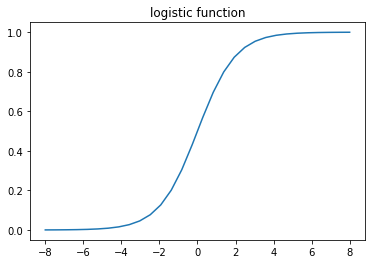

In [8]:
# logistic 결과를 그려 봅니다.
x = np.linspace(-8,8,30)
logistic_y = 1 / (1+np.exp(-x))

plt.title("logistic function")
plt.plot(x,logistic_y)

### F.softmax(): logit -> probability 
이게 나중에 찾으시면 softmax()가 logit을 확률값으로 변환해주는 역할을 합니다. PyTorch에서 또한 지원을 합니다. Module에 붙이는 nn.Softmax() 형태나 torch.nn.functional.softmax()가 있습니다. 이것을 호출하면 자동으로 logit을 각 클래스별로 확률값을 계산합니다.

##결론
결국 MLP는 logistic function의 해를 모델링하는 것이 되었습니다. Logistic Regression또는 Classification이라고 이야기 합니다. 여기에 학습의 손실을 CrossEntropy로 측정하였습니다.

---
자세한 사항은 [ratsgo의 logistic](https://ratsgo.github.io/machine%20learning/2017/04/02/logistic/)을 참조 바랍니다.